In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [2]:
votes = pd.read_csv("votes.csv")

In [3]:
votes

,audio1,audio2,audio1 wins,time,id
0,validation_audio/XC601791.wav,gan_inference/820.wav,True,15/03/2024 10:42:13,7534623972701592
1,validation_audio/XC673591.wav,vae_inference/751.wav,False,15/03/2024 10:42:27,7534623972701592
2,vaegan_inference/806.wav,vae_inference/316.wav,False,15/03/2024 10:44:09,1151052753934839
3,vaegan_inference/953.wav,vae_inference/7.wav,False,15/03/2024 10:44:42,6716292500392066
4,vaegan_inference/220.wav,vae_inference/548.wav,False,15/03/2024 10:44:43,6716292500392066
...,...,...,...,...,...
669,gan_inference/270.wav,vaegan_inference/59.wav,False,17/03/2024 15:34:17,4669732685685392
670,vae_inference/162.wav,audio_from_peak_processed/XC380950.wav,False,17/03/2024 15:34:23,4669732685685392
671,vaegan_inference/761.wav,audio_from_peak_processed/XC564160.wav,True,17/03/2024 15:34:29,4669732685685392
672,vaegan_inference/119.wav,audio_from_peak_processed/XC679867.wav,False,17/03/2024 15:34:36,4669732685685392


In [4]:
def clean_model_name(name):
    return {
        "gan_inference": "gan",
        "vae_inference": "vae",
        "vaegan_inference": "vae-gan",
        "vae_inference_peak": "vae peak",
        "gan_inference_peak": "gan peak",
        "vaegan_inference_peak": "vae-gan peak",
        "validation_audio": "validation",
        "audio_from_peak_processed": "validation_peak"
    }[name]

In [5]:
votes["audio_win"] = votes["audio2"]
votes["audio_lose"] = votes["audio1"]
mask = votes["audio1 wins"]
votes.loc[mask, "audio_win"] = votes.loc[mask, "audio1"]
votes.loc[mask, "audio_lose"] = votes.loc[mask, "audio2"]
votes["model_win"] = list(map(lambda x: clean_model_name(x.split("/")[0]), votes["audio_win"]))
votes["model_lose"] = list(map(lambda x: clean_model_name(x.split("/")[0]), votes["audio_lose"]))

In [6]:
votes

,audio1,audio2,audio1 wins,time,id,audio_win,audio_lose,model_win,model_lose
0,validation_audio/XC601791.wav,gan_inference/820.wav,True,15/03/2024 10:42:13,7534623972701592,validation_audio/XC601791.wav,gan_inference/820.wav,validation,gan
1,validation_audio/XC673591.wav,vae_inference/751.wav,False,15/03/2024 10:42:27,7534623972701592,vae_inference/751.wav,validation_audio/XC673591.wav,vae,validation
2,vaegan_inference/806.wav,vae_inference/316.wav,False,15/03/2024 10:44:09,1151052753934839,vae_inference/316.wav,vaegan_inference/806.wav,vae,vae-gan
3,vaegan_inference/953.wav,vae_inference/7.wav,False,15/03/2024 10:44:42,6716292500392066,vae_inference/7.wav,vaegan_inference/953.wav,vae,vae-gan
4,vaegan_inference/220.wav,vae_inference/548.wav,False,15/03/2024 10:44:43,6716292500392066,vae_inference/548.wav,vaegan_inference/220.wav,vae,vae-gan
...,...,...,...,...,...,...,...,...,...
669,gan_inference/270.wav,vaegan_inference/59.wav,False,17/03/2024 15:34:17,4669732685685392,vaegan_inference/59.wav,gan_inference/270.wav,vae-gan,gan
670,vae_inference/162.wav,audio_from_peak_processed/XC380950.wav,False,17/03/2024 15:34:23,4669732685685392,audio_from_peak_processed/XC380950.wav,vae_inference/162.wav,validation_peak,vae
671,vaegan_inference/761.wav,audio_from_peak_processed/XC564160.wav,True,17/03/2024 15:34:29,4669732685685392,vaegan_inference/761.wav,audio_from_peak_processed/XC564160.wav,vae-gan,validation_peak
672,vaegan_inference/119.wav,audio_from_peak_processed/XC679867.wav,False,17/03/2024 15:34:36,4669732685685392,audio_from_peak_processed/XC679867.wav,vaegan_inference/119.wav,validation_peak,vae-gan


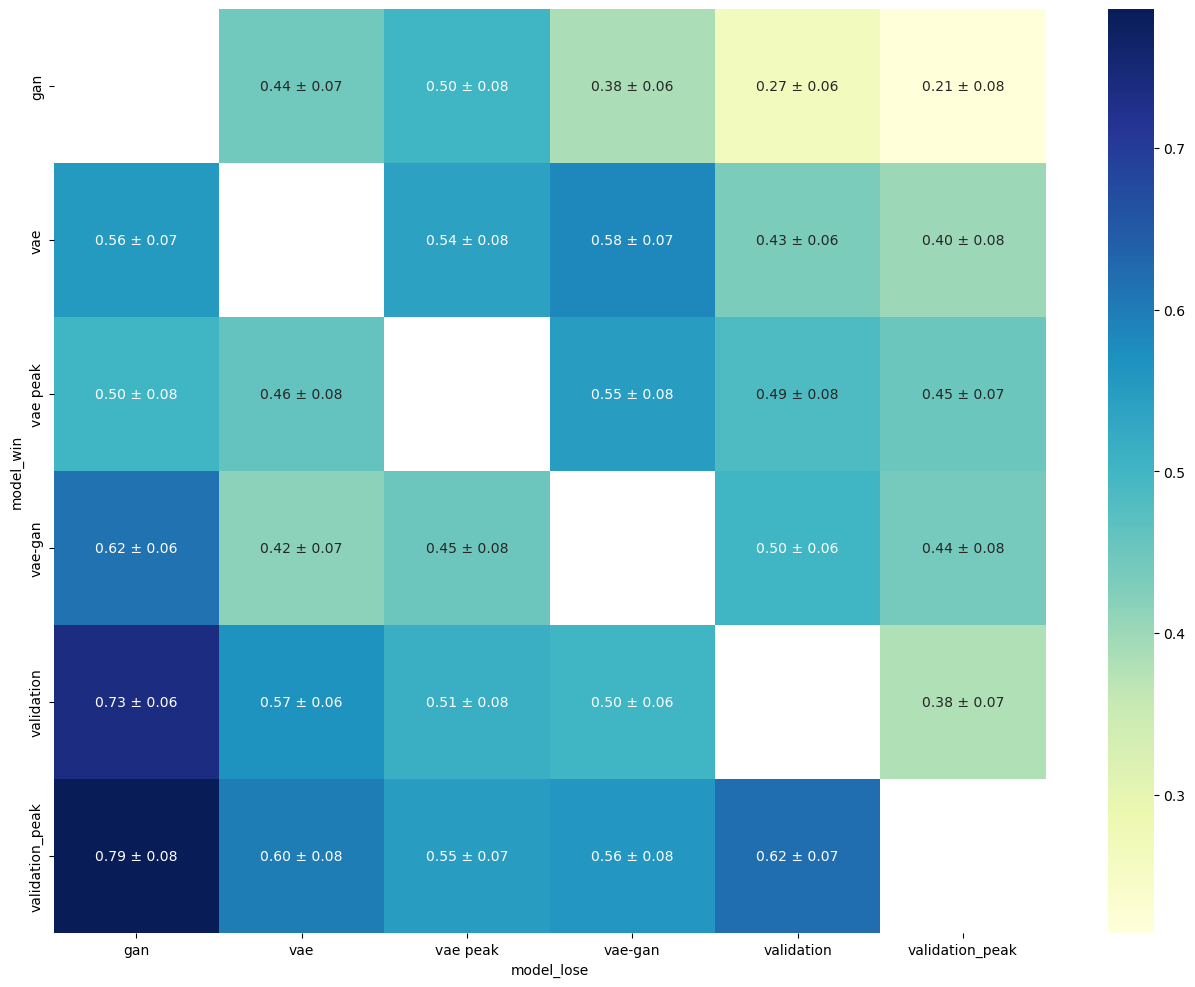

In [7]:
plt.rcParams["figure.figsize"] = (16,12)

def calculate_confidence_interval(n, p_hat, confidence_level=0.95):
    standard_error = np.sqrt(p_hat * (1 - p_hat) / n)
    z_score = stats.norm.ppf((1 + confidence_level) / 2)
    margin_of_error = z_score * standard_error / 2

    return margin_of_error

win_matrix = pd.crosstab(votes['model_win'], votes['model_lose'])

n_duels = win_matrix + win_matrix.T # wins + losses
win_rate_matrix = win_matrix.divide(n_duels, axis=0)

margin_of_error = calculate_confidence_interval(n_duels, win_rate_matrix)


ax = sns.heatmap(win_rate_matrix, annot=True, fmt=".2f", cmap="YlGnBu")

# Add the error interval to the annotations
win_rate_matrix = win_rate_matrix.to_numpy()
margin_of_error = margin_of_error.to_numpy()
for k, text in list(enumerate(ax.texts)):
    i = k // (len(win_rate_matrix) - 1)
    j = k%(len(win_rate_matrix) - 1)
    if j >= i:
        j+= 1

    text.set_text(f"{win_rate_matrix[i, j]:.2f} ± {margin_of_error[i, j]:.2f}")

plt.savefig("human_eval.png")
plt.show()

In [8]:
n_duels.sum().sum() / 2

674.0

In [9]:
n_duels

model_lose,gan,vae,vae peak,vae-gan,validation,validation_peak
model_win,,,,,,
gan,0,45,38,65,49,28
vae,45,0,37,48,58,40
vae peak,38,37,0,40,37,51
vae-gan,65,48,40,0,62,34
validation,49,58,37,62,0,42
validation_peak,28,40,51,34,42,0
